Project M3 Submission B1, Team 1

# Load Data & Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
!pip -q install gower
import gower

In [ ]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-06-13/safi_data.csv"
safi = pd.read_csv(url)

In [ ]:
print("Shape:", safi.shape)
safi.head()

Shape: (131, 14)


,key_ID,village,interview_date,no_membrs,years_liv,respondent_wall_type,rooms,memb_assoc,affect_conflicts,liv_count,items_owned,no_meals,months_lack_food,instanceID
0,1,God,2016-11-17T00:00:00Z,3,4,muddaub,1,NaN,NaN,1,bicycle;television;solar_panel;table,2,Jan,uuid:ec241f2c-0609-46ed-b5e8-fe575f6cefef
1,1,God,2016-11-17T00:00:00Z,7,9,muddaub,1,yes,once,3,cow_cart;bicycle;radio;cow_plough;solar_panel;...,2,Jan;Sept;Oct;Nov;Dec,uuid:099de9c9-3e5e-427b-8452-26250e840d6e
2,3,God,2016-11-17T00:00:00Z,10,15,burntbricks,1,NaN,NaN,1,solar_torch,2,Jan;Feb;Mar;Oct;Nov;Dec,uuid:193d7daf-9582-409b-bf09-027dd36f9007
3,4,God,2016-11-17T00:00:00Z,7,6,burntbricks,1,NaN,NaN,2,bicycle;radio;cow_plough;solar_panel;mobile_phone,2,Sept;Oct;Nov;Dec,uuid:148d1105-778a-4755-aa71-281eadd4a973
4,5,God,2016-11-17T00:00:00Z,7,40,burntbricks,1,NaN,NaN,4,motorcyle;radio;cow_plough;mobile_phone,2,Aug;Sept;Oct;Nov,uuid:2c867811-9696-4966-9866-f35c3e97d02d


Feature Engineering

In [ ]:
# Clean categorical
for c in ["memb_assoc","affect_conflicts"]:
    safi[c] = safi[c].fillna("unknown").str.lower().str.strip()

# Food insecurity count
safi["months_lack_food_count"] = (
    safi["months_lack_food"]
    .fillna("")
    .str.split(";")
    .apply(lambda x: len([m for m in x if m.strip() not in ["none",""]]))
)

# Asset count
safi["items_owned_count"] = (
    safi["items_owned"]
    .fillna("")
    .str.split(";")
    .apply(lambda x: len([i for i in x if i.strip() != ""]))
)


Numeric Feature Set (Used Across Methods)

In [ ]:
features = [
    "no_membrs",
    "liv_count",
    "rooms",
    "no_meals",
    "months_lack_food_count",
    "years_liv",
    "items_owned_count"
]

X = safi[features].apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

EDA

In [ ]:
#Distributions (for every clustering feature)
cluster_features = [
    "no_membrs",
    "liv_count",
    "rooms", "no_meals",
    "months_lack_food_count",
    "years_liv",
    "items_owned_count"
]

cluster_features = [c for c in cluster_features if c in safi.columns]

safi[cluster_features].describe()

,no_membrs,liv_count,rooms,no_meals,months_lack_food_count,years_liv,items_owned_count
count,131.00000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,7.19084,2.366412,1.740458,2.603053,2.320611,23.053435,4.740458
std,3.17227,1.082775,1.092547,0.491143,1.997179,16.913041,3.153966
min,2.00000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000
25%,5.00000,1.000000,1.000000,2.000000,0.000000,12.000000,2.000000
50%,7.00000,2.000000,1.000000,3.000000,2.000000,20.000000,5.000000
75%,9.00000,3.000000,2.000000,3.000000,3.000000,27.500000,7.000000
max,19.00000,5.000000,8.000000,3.000000,11.000000,96.000000,15.000000


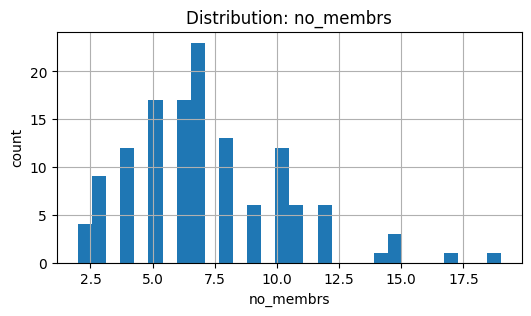

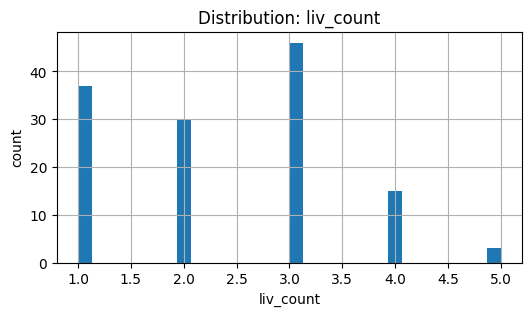

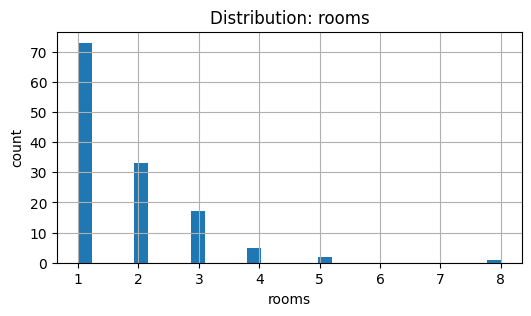

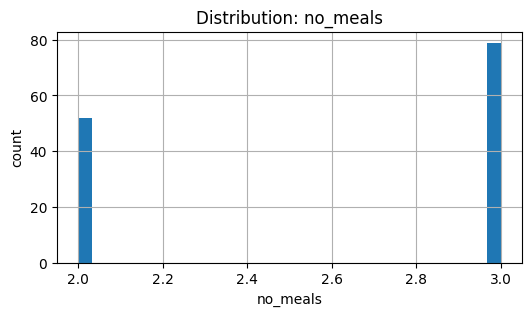

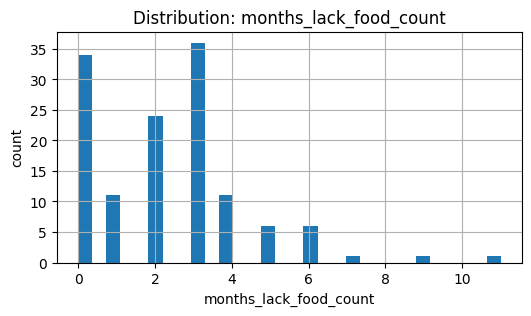

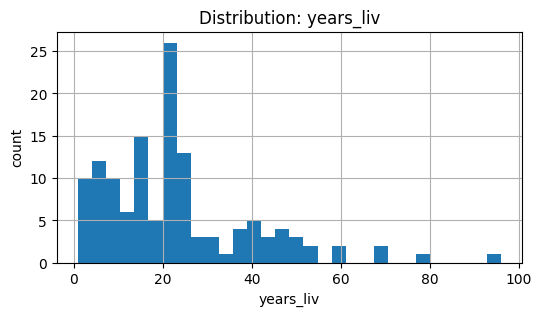

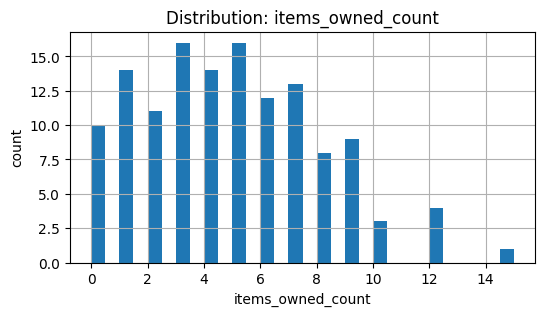

In [ ]:
for c in cluster_features:
    plt.figure(figsize=(6,3))
    safi[c].hist(bins=30)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()

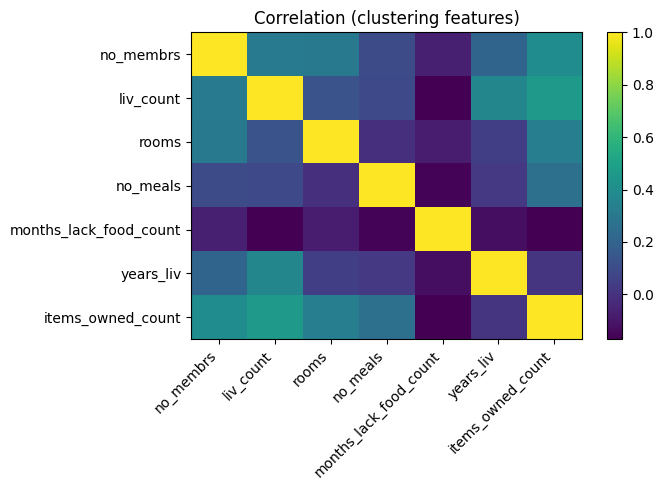

In [ ]:
#Correlation heatmap
corr = safi[cluster_features].corr(numeric_only=True)

plt.figure(figsize=(7,5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Correlation (clustering features)")
plt.tight_layout()
plt.show()

In [ ]:
# Group comparisons (membership/village vs features)
if "memb_assoc" in safi.columns:
    display(safi.groupby("memb_assoc")[cluster_features].mean(numeric_only=True))

if "village" in safi.columns:
    display(safi.groupby("village")[cluster_features].mean(numeric_only=True).head(10))

,no_membrs,liv_count,rooms,no_meals,months_lack_food_count,years_liv,items_owned_count
memb_assoc,,,,,,,
no,7.406780,2.525424,1.745763,2.610169,2.000000,22.406780,5.152542
unknown,5.769231,1.897436,1.692308,2.538462,2.820513,20.128205,3.487179
yes,8.484848,2.636364,1.787879,2.666667,2.303030,27.666667,5.484848


,no_membrs,liv_count,rooms,no_meals,months_lack_food_count,years_liv,items_owned_count
village,,,,,,,
Chirodzo,7.076923,2.256410,1.974359,2.615385,2.102564,23.615385,4.538462
God,6.860465,2.232558,1.534884,2.558140,3.000000,20.418605,3.976744
Ruaca,7.571429,2.571429,1.734694,2.632653,1.897959,24.918367,5.571429


KMeans — Elbow + Silhouette

Elbow

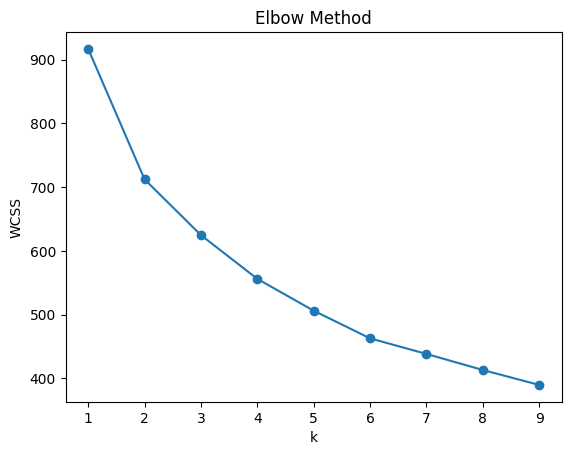

In [ ]:
wcss = []
for k in range(1,10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(1,10), wcss, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.show()

Silhouette

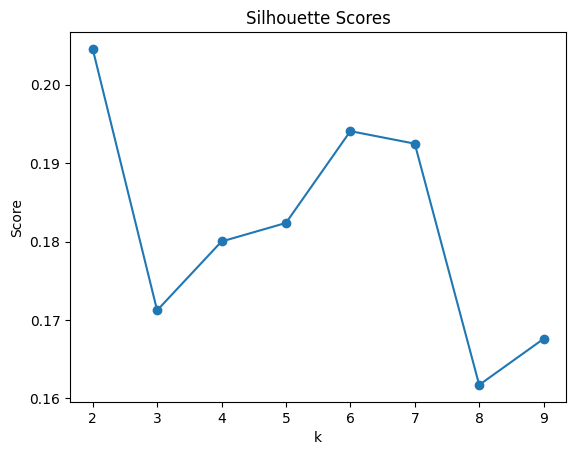

In [ ]:
sil_scores = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2,10), sil_scores, marker="o")
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

Fit Final KMeans

In [ ]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
safi["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

Improved Outlier Detection

In [ ]:
centroids = kmeans.cluster_centers_
labels = safi["kmeans_cluster"].values

distances = np.linalg.norm(X_scaled - centroids[labels], axis=1)
safi["distance_to_centroid"] = distances

safi["distance_z"] = (
    safi.groupby("kmeans_cluster")["distance_to_centroid"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

safi["economic_outlier"] = safi["distance_z"] > 2

PCA Visualization

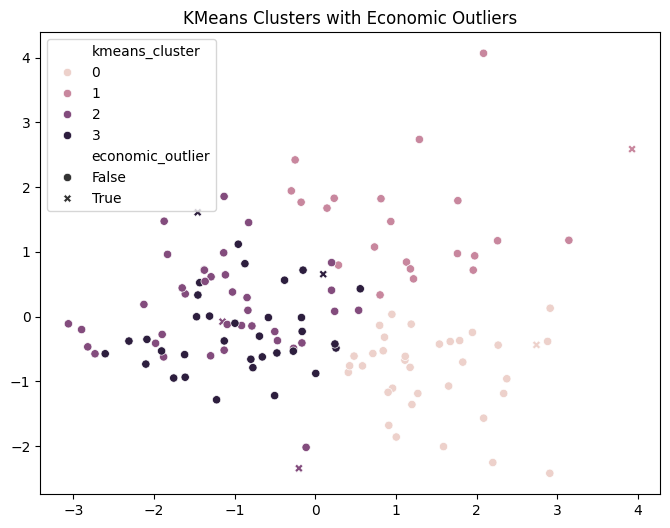

In [ ]:
coords = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0],
    y=coords[:,1],
    hue=safi["kmeans_cluster"],
    style=safi["economic_outlier"]
)
plt.title("KMeans Clusters with Economic Outliers")
plt.show()

Hierarchical (Ward)

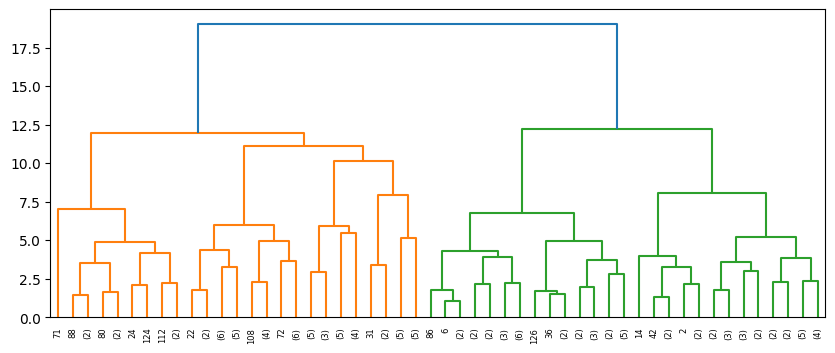

In [ ]:
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="level", p=5)
plt.show()

safi["hier_cluster"] = fcluster(Z, t=best_k, criterion="maxclust")

Gower Mixed Clustering

In [ ]:
mixed_features = features + ["memb_assoc","affect_conflicts"]

X_mixed = safi[mixed_features].copy()

D = gower.gower_matrix(X_mixed)
D_condensed = squareform(D, checks=False)

Z_avg = linkage(D_condensed, method="average")
safi["gower_cluster"] = fcluster(Z_avg, t=best_k, criterion="maxclust")

Interpretation Layer

In [ ]:
safi.groupby("kmeans_cluster")[features].mean()

display(pd.crosstab(safi["kmeans_cluster"], safi["village"], normalize="index"))


display(pd.crosstab(safi["kmeans_cluster"], safi["memb_assoc"], normalize="index"))


display(pd.crosstab(safi["kmeans_cluster"], safi["affect_conflicts"], normalize="index"))

village,Chirodzo,God,Ruaca
kmeans_cluster,,,
0,0.285714,0.257143,0.457143
1,0.363636,0.227273,0.409091
2,0.230769,0.435897,0.333333
3,0.342857,0.342857,0.314286


memb_assoc,no,unknown,yes
kmeans_cluster,,,
0,0.457143,0.200000,0.342857
1,0.454545,0.227273,0.318182
2,0.384615,0.410256,0.205128
3,0.514286,0.314286,0.171429


affect_conflicts,frequently,more_once,never,once,unknown
kmeans_cluster,,,,,
0,0.114286,0.200000,0.428571,0.057143,0.200000
1,0.045455,0.363636,0.318182,0.045455,0.227273
2,0.051282,0.102564,0.384615,0.051282,0.410256
3,0.057143,0.285714,0.257143,0.085714,0.314286


In [ ]:
safi.groupby("hier_cluster")[features].mean()

display(pd.crosstab(safi["hier_cluster"], safi["village"], normalize="index"))


display(pd.crosstab(safi["hier_cluster"], safi["memb_assoc"], normalize="index"))


display(pd.crosstab(safi["hier_cluster"], safi["affect_conflicts"], normalize="index"))

village,Chirodzo,God,Ruaca
hier_cluster,,,
1,0.333333,0.416667,0.250000
2,0.321429,0.214286,0.464286
3,0.333333,0.363636,0.303030
4,0.200000,0.466667,0.333333


memb_assoc,no,unknown,yes
hier_cluster,,,
1,0.583333,0.250000,0.166667
2,0.464286,0.160714,0.375000
3,0.484848,0.363636,0.151515
4,0.333333,0.500000,0.166667


affect_conflicts,frequently,more_once,never,once,unknown
hier_cluster,,,,,
1,0.000000,0.166667,0.500000,0.083333,0.250000
2,0.125000,0.285714,0.357143,0.071429,0.160714
3,0.060606,0.242424,0.272727,0.060606,0.363636
4,0.000000,0.100000,0.366667,0.033333,0.500000


In [ ]:
safi.groupby("gower_cluster")[features].mean()

display(pd.crosstab(safi["gower_cluster"], safi["village"], normalize="index"))


display(pd.crosstab(safi["gower_cluster"], safi["memb_assoc"], normalize="index"))


display(pd.crosstab(safi["gower_cluster"], safi["affect_conflicts"], normalize="index"))

village,Chirodzo,God,Ruaca
gower_cluster,,,
1,0.307692,0.461538,0.230769
2,0.271186,0.254237,0.474576
3,0.500000,0.000000,0.500000
4,0.322581,0.322581,0.354839


memb_assoc,no,unknown,yes
gower_cluster,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


affect_conflicts,frequently,more_once,never,once,unknown
gower_cluster,,,,,
1,0.000000,0.000000,0.000000,0.000000,1.0
2,0.033898,0.271186,0.644068,0.050847,0.0
3,0.000000,0.500000,0.500000,0.000000,0.0
4,0.225806,0.387097,0.225806,0.161290,0.0
